## 2.2 MLP Regressor for Price Prediction in Bangalore

### Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import wandb
from sklearn.metrics import r2_score

In [3]:
file_path = "Bengaluru_House_Data.csv"  # Update the file path if needed
df = pd.read_csv(file_path)
print(df.head())

              area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  
3  Soiewre       1521   3.0      1.0   95.00  
4      NaN       1200   2.0      1.0   51.00  


In [4]:
# Handling missing values
print(df.isnull().sum())
df.drop(columns=['society'], inplace=True) # As most empty values in society which cannot be replaced by something as it is unique for all.
df['bath'].fillna(df['bath'].median(), inplace=True)
df['balcony'].fillna(df['balcony'].median(), inplace=True)

df['size'] = df['size'].str.extract(r'(\d+)').astype(float)
df['size'].fillna(df['size'].median(), inplace=True)
print(df[df['location'].isnull()]) # Only 1 value, so the same location as the society is located from other entry (manually)
print(df.isnull().sum())

area_type          0
availability       0
location           0
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64
Empty DataFrame
Columns: [area_type, availability, location, size, total_sqft, bath, balcony, price]
Index: []
area_type       0
availability    0
location        0
size            0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_17092\1877906524.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bath'].fillna(df['bath'].median(), inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_17092\1877906524.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [5]:
print(df['availability'].unique())
df['availability'] = df['availability'].apply(
    lambda x: 'Not Ready' if ('Ready To Move' not in str(x) and 'Immediate Possession' not in str(x)) else 'Ready'
)
print(df['availability'].unique())
print(df.head())

['19-Dec' 'Ready To Move' '18-May' '18-Feb' '18-Nov' '20-Dec' '17-Oct'
 '21-Dec' '19-Sep' '20-Sep' '18-Mar' '20-Feb' '18-Apr' '20-Aug' '18-Oct'
 '19-Mar' '17-Sep' '18-Dec' '17-Aug' '19-Apr' '18-Jun' '22-Dec' '22-Jan'
 '18-Aug' '19-Jan' '17-Jul' '18-Jul' '21-Jun' '20-May' '19-Aug' '18-Sep'
 '17-May' '17-Jun' '21-May' '18-Jan' '20-Mar' '17-Dec' '16-Mar' '19-Jun'
 '22-Jun' '19-Jul' '21-Feb' 'Immediate Possession' '19-May' '17-Nov'
 '20-Oct' '20-Jun' '19-Feb' '21-Oct' '21-Jan' '17-Mar' '17-Apr' '22-May'
 '19-Oct' '21-Jul' '21-Nov' '21-Mar' '16-Dec' '22-Mar' '20-Jan' '21-Sep'
 '21-Aug' '14-Nov' '19-Nov' '15-Nov' '16-Jul' '15-Jun' '17-Feb' '20-Nov'
 '20-Jul' '16-Sep' '15-Oct' '15-Dec' '16-Oct' '22-Nov' '15-Aug' '17-Jan'
 '16-Nov' '20-Apr' '16-Jan' '14-Jul']
['Not Ready' 'Ready']
              area_type availability                  location  size  \
0  Super built-up  Area    Not Ready  Electronic City Phase II   2.0   
1            Plot  Area        Ready          Chikka Tirupathi   4.0   


(13320, 8)
               size    total_sqft          bath       balcony         price
count  13320.000000  13073.000000  13320.000000  13320.000000  13320.000000
mean       2.803979   1554.942029      2.688814      1.603378    112.565627
std        1.294214   1238.458773      1.338754      0.803067    148.971674
min        1.000000      1.000000      1.000000      0.000000      8.000000
25%        2.000000   1100.000000      2.000000      1.000000     50.000000
50%        3.000000   1275.000000      2.000000      2.000000     72.000000
75%        3.000000   1670.000000      3.000000      2.000000    120.000000
max       43.000000  52272.000000     40.000000      3.000000   3600.000000


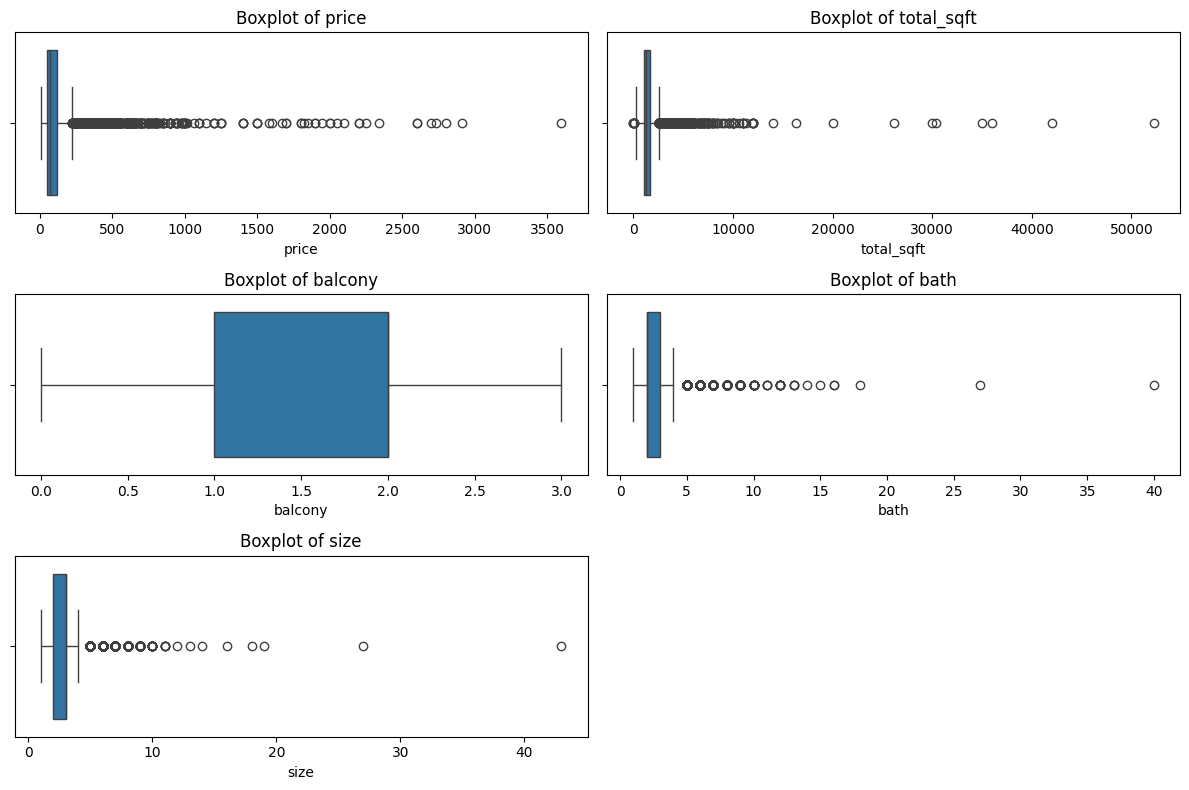

(10708, 8)


In [6]:
# Removing outliers
print(df.shape)
df['total_sqft'] = pd.to_numeric(df['total_sqft'], errors='coerce')
print(df.describe())

features = ['price', 'total_sqft', 'balcony', 'bath', 'size']

plt.figure(figsize=(12, 8))

for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_cleaned = df.copy()
for col in ['price', 'total_sqft', 'balcony', 'bath', 'size']:
    df_cleaned = remove_outliers(df_cleaned, col)
print(df_cleaned.shape) 

In [7]:
print(df_cleaned['location'].unique())
df_cleaned = pd.get_dummies(df_cleaned, columns=['area_type', 'availability', 'location'])
print(df_cleaned.head())

['Electronic City Phase II' 'Uttarahalli' 'Lingadheeranahalli' ...
 'Sarvobhogam Nagar' '12th cross srinivas nagar banshankari 3rd stage'
 'Abshot Layout']
   size  total_sqft  bath  balcony  price  area_type_Built-up  Area  \
0   2.0      1056.0   2.0      1.0  39.07                     False   
2   3.0      1440.0   2.0      3.0  62.00                      True   
3   3.0      1521.0   3.0      1.0  95.00                     False   
4   2.0      1200.0   2.0      1.0  51.00                     False   
5   2.0      1170.0   2.0      1.0  38.00                     False   

   area_type_Carpet  Area  area_type_Plot  Area  \
0                   False                 False   
2                   False                 False   
3                   False                 False   
4                   False                 False   
5                   False                 False   

   area_type_Super built-up  Area  availability_Not Ready  ...  \
0                            True           

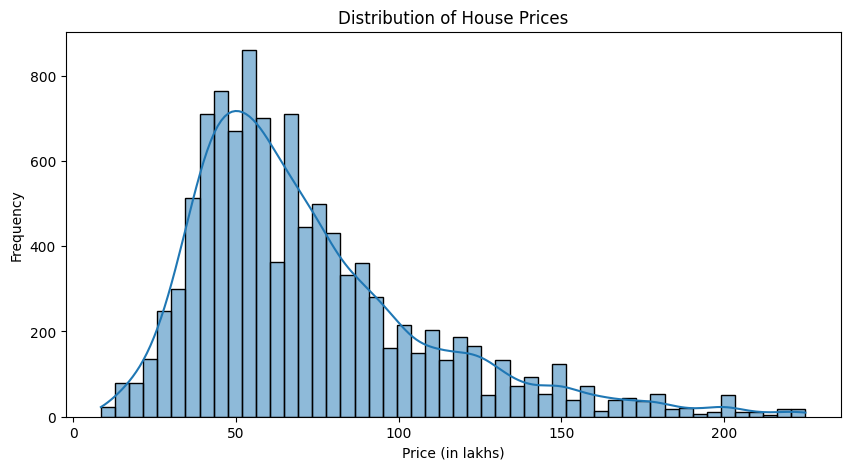

In [8]:
plt.figure(figsize=(10, 5))

sns.histplot(df_cleaned['price'], bins=50, kde=True)

plt.title('Distribution of House Prices')
plt.xlabel('Price (in lakhs)')
plt.ylabel('Frequency')

plt.show()

In [ ]:
# Split into train, validation, and test sets
x = df_cleaned.drop(columns=['price'])
y = df_cleaned['price']

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Normalize data (Standardization)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape,y_test.shape)

x_train_np, y_train_np = np.array(x_train), np.array(y_train)
x_val_np, y_val_np = np.array(x_val), np.array(y_val)
x_test_np, y_test_np = np.array(x_test), np.array(y_test)
y_train_np=y_train_np.reshape(-1, 1)
y_val_np=y_val_np.reshape(-1, 1)
y_test_np=y_test_np.reshape(-1, 1)

(8566, 1105) (8566,)
(1071, 1105) (1071,)
(1071, 1105) (1071,)


In [10]:
class MLP():
    def __init__(self,input_dim,hidden_dim,output_dim,activation):
        self.in_hidden_weights=np.random.randn(input_dim, hidden_dim)*np.sqrt(2/input_dim)
        self.out_hidden_weights=np.random.randn(hidden_dim,output_dim)*np.sqrt(2/hidden_dim)
        self.bias_hidden = np.zeros((1, hidden_dim))
        self.bias_output=np.zeros((1,output_dim))
        self.activation=activation
        
    def apply_activation(self,x):
        if self.activation=='relu':
            activation = np.maximum(0, x)  
        elif self.activation=='sigmoid':
            activation = 1 / (1 + np.exp(-x))
        elif self.activation=='tanh':
            activation = np.tanh(x)  
            
        return activation
    
    def apply_derivative(self,x):
        if self.activation=='relu':
            derivative=np.where(x > 0, 1, 0)
        elif self.activation=='sigmoid':
            activation = 1 / (1 + np.exp(-x))
            derivative= activation * (1 - activation)  
        elif self.activation=='tanh':
            activation = np.tanh(x)  
            derivative = 1 - activation ** 2  
            
        return derivative
    
    def forward(self,x):
        self.hidden_layer_input=np.dot(x,self.in_hidden_weights)+self.bias_hidden
        self.hidden_layer_output=self.apply_activation(self.hidden_layer_input)
        self.final_input=np.dot(self.hidden_layer_output,self.out_hidden_weights)+self.bias_output
        return self.final_input
    
    def backward_propogation(self,x,y_true,y_pred,learning_rate):
        batch_size=x.shape[0]
        output_layer_error=(y_pred-y_true)/batch_size
        hidden_layer_error=(np.dot(output_layer_error,self.out_hidden_weights.T))*self.apply_derivative(self.hidden_layer_input) # total contribution of each hidden neuron to the overall output error and multiplied by derivative as scales the hidden error based on how much each hidden neuron is "activated."
        

        self.out_hidden_weights=self.out_hidden_weights-learning_rate*(np.dot(self.hidden_layer_output.T,output_layer_error))
        self.bias_output=self.bias_output-learning_rate*(np.sum(output_layer_error,axis=0,keepdims=True))
        
        self.in_hidden_weights=self.in_hidden_weights-learning_rate*(np.dot(x.T,hidden_layer_error))
        self.bias_hidden=self.bias_hidden-learning_rate*(np.sum(hidden_layer_error,axis=0,keepdims=True))

    def mse_loss(self,y_true,y_pred):
        loss = np.mean((y_pred - y_true)**2)
        return loss
        
    def predict(self, x):
        return self.forward(x)
    
    def rmse(self,mse):
        rmse = np.sqrt(mse)
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    def r2_score(elf,y_test,y_pred):
        r2 = r2_score(y_test, y_pred)
        print(f"R-squared (R²): {r2:.4f}")
    
    def train(self,x_train,y_true,num_epochs,learning_rate,x_val,y_val,batch_size):
        
        total_num_train_samples=x_train.shape[0]
        if batch_size is None:
            batch_size=total_num_train_samples
            

        for epoch in tqdm(range(num_epochs), desc="Training Progress"):
            
            indices=np.random.permutation(total_num_train_samples)
            x_shuffled_train = x_train[indices]
            y_shuffled_train= y_true[indices]
            epoch_loss = 0
            num_batches = 0
        
            for i in range(0, total_num_train_samples, batch_size):
                end = min(i + batch_size, total_num_train_samples)
                x_batch = x_shuffled_train[i:end]
                y_batch = y_shuffled_train[i:end]
                
                y_pred=self.forward(x_batch)
                self.backward_propogation(x_batch,y_batch,y_pred,learning_rate)
                
                loss=self.mse_loss(y_batch,y_pred)
                epoch_loss=epoch_loss+loss
                
                num_batches=num_batches+1
                
            y_pred_val=self.predict(x_val)
            val_loss=self.mse_loss(y_val,y_pred_val)
            
            wandb.log({"Epoch": epoch, "Train Loss": epoch_loss/num_batches, "Validation Loss": val_loss})
            
            if (epoch+1)%10==0:
                print(f"Epoch: {epoch},Train Loss:{epoch_loss/num_batches}")
                print(f"Epoch: {epoch},Validation Loss:{val_loss}")
            elif epoch==0:
                print(f"Epoch: {epoch},Loss:{epoch_loss/num_batches}")
                print(f"Epoch: {epoch},Validation Loss:{val_loss}")
            

### RELU

In [10]:
np.random.seed(42)
input_dim=1105
hidden_dim=64
learning_rate=0.01
num_epochs=100
activation='relu'
batch_size=None
output_dim=1

In [11]:
wandb.init(project="SMAI-A2", name="2.2-Relu-BGD")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ketakishetye0619 (ketakishetye0619-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Initialising model


Training Progress:   1%|          | 1/100 [00:00<00:11,  8.53it/s]

Epoch: 0,Loss:6670.435992181684
Epoch: 0,Validation Loss:5721.409716945516


Training Progress:  11%|█         | 11/100 [00:01<00:11,  8.03it/s]

Epoch: 9,Train Loss:344.3715603887008
Epoch: 9,Validation Loss:599.1245216567423


Training Progress:  21%|██        | 21/100 [00:02<00:09,  8.46it/s]

Epoch: 19,Train Loss:311.587639313171
Epoch: 19,Validation Loss:566.2171845852986


Training Progress:  31%|███       | 31/100 [00:03<00:08,  8.16it/s]

Epoch: 29,Train Loss:300.2000344400514
Epoch: 29,Validation Loss:554.5597586523267


Training Progress:  41%|████      | 41/100 [00:04<00:07,  8.22it/s]

Epoch: 39,Train Loss:292.7317077524465
Epoch: 39,Validation Loss:547.7290116707371


Training Progress:  51%|█████     | 51/100 [00:06<00:05,  8.23it/s]

Epoch: 49,Train Loss:286.1689156312358
Epoch: 49,Validation Loss:541.4844681969748


Training Progress:  61%|██████    | 61/100 [00:07<00:04,  8.15it/s]

Epoch: 59,Train Loss:279.90125012434635
Epoch: 59,Validation Loss:535.9533421866245


Training Progress:  71%|███████   | 71/100 [00:08<00:03,  8.10it/s]

Epoch: 69,Train Loss:274.19218273219894
Epoch: 69,Validation Loss:530.7218325162254


Training Progress:  81%|████████  | 81/100 [00:09<00:02,  8.08it/s]

Epoch: 79,Train Loss:269.0879864108806
Epoch: 79,Validation Loss:526.2335394176928


Training Progress:  91%|█████████ | 91/100 [00:11<00:01,  7.87it/s]

Epoch: 89,Train Loss:264.04095361215934
Epoch: 89,Validation Loss:520.3320205381686


Training Progress: 100%|██████████| 100/100 [00:12<00:00,  8.13it/s]

Epoch: 99,Train Loss:259.3883647255201
Epoch: 99,Validation Loss:515.3154962736977
Final Test Loss 506.9603971060072
Root Mean Squared Error (RMSE): 22.5158
R-squared (R²): 0.6099


Epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
Train Loss,█▇▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,99
Train Loss,259.38836
Validation Loss,515.3155


message_loop has been closed
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\wandb\sdk\lib\sock_client.py", line 208, in _read_packet_bytes
    data = self._sock.recv(self._bufsize)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\wandb\sdk\interface\router_sock.py", line 27, in _read_message
    return self._sock_client.read_server_response(timeout=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalC

In [11]:
np.random.seed(42)
input_dim=1105
hidden_dim=128
learning_rate=0.01
num_epochs=100
activation='relu'
batch_size=None
output_dim=1

In [13]:
wandb.init(project="SMAI-A2", name="2.2-Relu-BGD-Hyperparam-1")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ketakishetye0619 (ketakishetye0619-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Initialising model


Training Progress:   1%|          | 1/100 [00:00<00:13,  7.10it/s]

Epoch: 0,Loss:6636.734745056487
Epoch: 0,Validation Loss:4807.588479549614


Training Progress:  11%|█         | 11/100 [00:01<00:13,  6.60it/s]

Epoch: 9,Train Loss:351.09765280188986
Epoch: 9,Validation Loss:622.3367598114809


Training Progress:  21%|██        | 21/100 [00:03<00:11,  6.68it/s]

Epoch: 19,Train Loss:311.30916205782114
Epoch: 19,Validation Loss:585.7641543013171


Training Progress:  31%|███       | 31/100 [00:04<00:10,  6.52it/s]

Epoch: 29,Train Loss:298.28700500552344
Epoch: 29,Validation Loss:573.4449364489319


Training Progress:  41%|████      | 41/100 [00:06<00:09,  6.25it/s]

Epoch: 39,Train Loss:290.12121417609535
Epoch: 39,Validation Loss:565.5590125022932


Training Progress:  51%|█████     | 51/100 [00:07<00:07,  6.77it/s]

Epoch: 49,Train Loss:283.68040677762764
Epoch: 49,Validation Loss:559.4602941066272


Training Progress:  61%|██████    | 61/100 [00:09<00:05,  6.52it/s]

Epoch: 59,Train Loss:278.10461864232843
Epoch: 59,Validation Loss:554.0375495307159


Training Progress:  71%|███████   | 71/100 [00:10<00:04,  6.68it/s]

Epoch: 69,Train Loss:273.0165968536593
Epoch: 69,Validation Loss:549.0241678845306


Training Progress:  81%|████████  | 81/100 [00:12<00:02,  6.56it/s]

Epoch: 79,Train Loss:268.07721731157784
Epoch: 79,Validation Loss:543.9548388559442


Training Progress:  91%|█████████ | 91/100 [00:14<00:01,  6.02it/s]

Epoch: 89,Train Loss:263.51083547269343
Epoch: 89,Validation Loss:538.8957774880508


Training Progress: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]

Epoch: 99,Train Loss:259.1843736376551
Epoch: 99,Validation Loss:534.3134134674943
Final Test Loss 527.242490981299
Root Mean Squared Error (RMSE): 22.9618
R-squared (R²): 0.5943


Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
Train Loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,99
Train Loss,259.18437
Validation Loss,534.31341


In [ ]:
np.random.seed(42)
input_dim=1105
hidden_dim=64
learning_rate=0.001
num_epochs=100
activation='relu'
batch_size=None
output_dim=1

In [19]:
wandb.init(project="SMAI-A2", name="2.2-Relu-BGD-Hyperparam-2")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   1%|          | 1/100 [00:00<00:13,  7.21it/s]

Epoch: 0,Loss:6658.714111771921
Epoch: 0,Validation Loss:6714.6559161598625


Training Progress:  11%|█         | 11/100 [00:01<00:15,  5.88it/s]

Epoch: 9,Train Loss:4676.034041265708
Epoch: 9,Validation Loss:4833.318095332798


Training Progress:  21%|██        | 21/100 [00:03<00:12,  6.40it/s]

Epoch: 19,Train Loss:2657.5454105078875
Epoch: 19,Validation Loss:2818.3867495590716


Training Progress:  31%|███       | 31/100 [00:04<00:10,  6.37it/s]

Epoch: 29,Train Loss:1199.878358800066
Epoch: 29,Validation Loss:1423.8535539316492


Training Progress:  41%|████      | 41/100 [00:06<00:09,  6.41it/s]

Epoch: 39,Train Loss:692.7221412586205
Epoch: 39,Validation Loss:954.9179649705295


Training Progress:  51%|█████     | 51/100 [00:07<00:07,  6.75it/s]

Epoch: 49,Train Loss:520.5751818608517
Epoch: 49,Validation Loss:796.1930631290785


Training Progress:  61%|██████    | 61/100 [00:09<00:05,  6.65it/s]

Epoch: 59,Train Loss:440.0256199854146
Epoch: 59,Validation Loss:721.9693251829037


Training Progress:  70%|███████   | 70/100 [00:12<00:13,  2.19it/s]

Epoch: 69,Train Loss:397.22601077083766
Epoch: 69,Validation Loss:681.1804249502354


Training Progress:  80%|████████  | 80/100 [00:15<00:05,  3.94it/s]

Epoch: 79,Train Loss:372.61623152532246
Epoch: 79,Validation Loss:656.2622596163166


Training Progress:  91%|█████████ | 91/100 [00:17<00:01,  5.59it/s]

Epoch: 89,Train Loss:357.28854990333275
Epoch: 89,Validation Loss:639.8457783284483


Training Progress: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]

Epoch: 99,Train Loss:347.00717503030694
Epoch: 99,Validation Loss:628.3112986339443
Final Test Loss 612.7034644504447
Root Mean Squared Error (RMSE): 24.7528
R-squared (R²): 0.5285


Epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
Train Loss,██▇▇▆▆▅▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▇▇▇▆▅▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,99
Train Loss,347.00718
Validation Loss,628.3113


In [12]:
np.random.seed(42)
input_dim=1105
hidden_dim=64
learning_rate=0.00001
num_epochs=100
activation='relu'
batch_size=1
output_dim=1

In [13]:
wandb.init(project="SMAI-A2", name="2.2-Relu-SGD")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   1%|          | 1/100 [00:02<03:29,  2.12s/it]

Epoch: 0,Loss:2003.2588597972715
Epoch: 0,Validation Loss:904.7537909423013


Training Progress:  10%|█         | 10/100 [00:25<04:15,  2.84s/it]

Epoch: 9,Train Loss:340.4318685720114
Epoch: 9,Validation Loss:567.1816212823186


Training Progress:  20%|██        | 20/100 [00:52<03:30,  2.64s/it]

Epoch: 19,Train Loss:295.3892836055931
Epoch: 19,Validation Loss:517.5332237625089


Training Progress:  30%|███       | 30/100 [01:15<02:41,  2.30s/it]

Epoch: 29,Train Loss:272.4361452238796
Epoch: 29,Validation Loss:500.4266356763999


Training Progress:  40%|████      | 40/100 [01:38<02:18,  2.31s/it]

Epoch: 39,Train Loss:260.4273174304987
Epoch: 39,Validation Loss:508.7524530666421


Training Progress:  50%|█████     | 50/100 [02:01<01:55,  2.31s/it]

Epoch: 49,Train Loss:250.8376430047492
Epoch: 49,Validation Loss:494.9883083263947


Training Progress:  60%|██████    | 60/100 [02:26<01:38,  2.47s/it]

Epoch: 59,Train Loss:243.2486469883318
Epoch: 59,Validation Loss:499.5455304636649


Training Progress:  70%|███████   | 70/100 [02:46<01:02,  2.09s/it]

Epoch: 69,Train Loss:235.04685364476344
Epoch: 69,Validation Loss:495.6529054250018


Training Progress:  80%|████████  | 80/100 [03:09<00:49,  2.46s/it]

Epoch: 79,Train Loss:229.28943678509475
Epoch: 79,Validation Loss:482.75317770879377


Training Progress:  90%|█████████ | 90/100 [03:34<00:24,  2.41s/it]

Epoch: 89,Train Loss:224.91982074346677
Epoch: 89,Validation Loss:484.0698598903398


Training Progress: 100%|██████████| 100/100 [03:57<00:00,  2.37s/it]

Epoch: 99,Train Loss:220.33113679297787
Epoch: 99,Validation Loss:481.45532221458075
Final Test Loss 495.4913211409557
Root Mean Squared Error (RMSE): 22.2596
R-squared (R²): 0.6187


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
Train Loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,▇█▅▆▆▅▅▄▄▄▃▃▃▃▃▂▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁
Epoch,99
Train Loss,220.33114
Validation Loss,481.45532


In [24]:
np.random.seed(42)
input_dim=1105
hidden_dim=64
learning_rate=0.00001
num_epochs=100
activation='relu'
batch_size=1
output_dim=1

In [25]:
wandb.init(project="SMAI-A2", name="2.2-Relu-SGD-Hyperparam2")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   1%|          | 1/100 [00:02<03:21,  2.04s/it]

Epoch: 0,Loss:2003.2588597972715
Epoch: 0,Validation Loss:904.7537909423013


Training Progress:  10%|█         | 10/100 [00:20<03:07,  2.08s/it]

Epoch: 9,Train Loss:340.4318685720114
Epoch: 9,Validation Loss:567.1816212823186


Training Progress:  20%|██        | 20/100 [00:41<02:47,  2.10s/it]

Epoch: 19,Train Loss:295.3892836055931
Epoch: 19,Validation Loss:517.5332237625089


Training Progress:  30%|███       | 30/100 [01:02<02:25,  2.08s/it]

Epoch: 29,Train Loss:272.4361452238796
Epoch: 29,Validation Loss:500.4266356763999


Training Progress:  40%|████      | 40/100 [01:23<02:03,  2.05s/it]

Epoch: 39,Train Loss:260.4273174304987
Epoch: 39,Validation Loss:508.7524530666421


Training Progress:  50%|█████     | 50/100 [01:43<01:45,  2.11s/it]

Epoch: 49,Train Loss:250.8376430047492
Epoch: 49,Validation Loss:494.9883083263947


Training Progress:  60%|██████    | 60/100 [02:04<01:24,  2.11s/it]

Epoch: 59,Train Loss:243.2486469883318
Epoch: 59,Validation Loss:499.5455304636649


Training Progress:  70%|███████   | 70/100 [02:25<01:04,  2.14s/it]

Epoch: 69,Train Loss:235.04685364476344
Epoch: 69,Validation Loss:495.6529054250018


Training Progress:  80%|████████  | 80/100 [02:48<00:47,  2.39s/it]

Epoch: 79,Train Loss:229.28943678509475
Epoch: 79,Validation Loss:482.75317770879377


Training Progress:  90%|█████████ | 90/100 [03:11<00:21,  2.18s/it]

Epoch: 89,Train Loss:224.91982074346677
Epoch: 89,Validation Loss:484.0698598903398


Training Progress: 100%|██████████| 100/100 [03:31<00:00,  2.12s/it]

Epoch: 99,Train Loss:220.33113679297787
Epoch: 99,Validation Loss:481.45532221458075
Final Test Loss 495.4913211409557
Root Mean Squared Error (RMSE): 22.2596
R-squared (R²): 0.6187


Epoch,▁▁▂▃▃▃▃▃▃▄▅▅▆▆▆▆▆▆▇▇▇▇██▁▂▂▃▃▃▃▃▄▄▅▆▆▇▇█
Train Loss,█▆▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁
Validation Loss,█▃▃▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,99
Train Loss,220.33114
Validation Loss,481.45532


In [14]:
np.random.seed(42)
input_dim=1105
hidden_dim=128
learning_rate=0.00001
num_epochs=100
activation='relu'
batch_size=1
output_dim=1

In [15]:
wandb.init(project="SMAI-A2", name="2.2-Relu-SGD-Hyperaparam1")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   1%|          | 1/100 [00:03<05:23,  3.27s/it]

Epoch: 0,Loss:1795.485918645012
Epoch: 0,Validation Loss:815.7801583926724


Training Progress:  10%|█         | 10/100 [00:33<05:03,  3.37s/it]

Epoch: 9,Train Loss:327.39517713665845
Epoch: 9,Validation Loss:555.9512587338515


Training Progress:  20%|██        | 20/100 [01:06<04:21,  3.27s/it]

Epoch: 19,Train Loss:293.6453628310273
Epoch: 19,Validation Loss:537.5744303781689


Training Progress:  30%|███       | 30/100 [01:38<03:43,  3.19s/it]

Epoch: 29,Train Loss:268.50230537949983
Epoch: 29,Validation Loss:519.888840623259


Training Progress:  40%|████      | 40/100 [02:12<03:41,  3.69s/it]

Epoch: 39,Train Loss:257.42468118189123
Epoch: 39,Validation Loss:488.14555679930777


Training Progress:  50%|█████     | 50/100 [02:46<02:46,  3.34s/it]

Epoch: 49,Train Loss:247.05983718635977
Epoch: 49,Validation Loss:490.4340348612049


Training Progress:  60%|██████    | 60/100 [03:18<02:10,  3.25s/it]

Epoch: 59,Train Loss:238.9669894804888
Epoch: 59,Validation Loss:485.0987527063038


Training Progress:  70%|███████   | 70/100 [03:51<01:37,  3.25s/it]

Epoch: 69,Train Loss:235.13073584466633
Epoch: 69,Validation Loss:477.20468263062025


Training Progress:  80%|████████  | 80/100 [04:24<01:05,  3.27s/it]

Epoch: 79,Train Loss:229.68092445289818
Epoch: 79,Validation Loss:474.4555396100761


Training Progress:  90%|█████████ | 90/100 [04:56<00:31,  3.14s/it]

Epoch: 89,Train Loss:224.23680979823467
Epoch: 89,Validation Loss:470.17743772259


Training Progress: 100%|██████████| 100/100 [05:31<00:00,  3.32s/it]

Epoch: 99,Train Loss:221.1798097092855
Epoch: 99,Validation Loss:481.42830102235433
Final Test Loss 482.3488186335943
Root Mean Squared Error (RMSE): 21.9624
R-squared (R²): 0.6288


Epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇████
Train Loss,█▆▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▇▆▅▅▄▃▃▃▃▃▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,99
Train Loss,221.17981
Validation Loss,481.4283


In [14]:
np.random.seed(42)
input_dim=1105
hidden_dim=64
learning_rate=0.001
num_epochs=100
activation='relu'
batch_size=128
output_dim=1

In [15]:
wandb.init(project="SMAI-A2", name="2.2-Relu-MBGD")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   2%|▏         | 2/100 [00:00<00:17,  5.51it/s]

Epoch: 0,Loss:2417.762857684174
Epoch: 0,Validation Loss:835.5742530720805


Training Progress:  11%|█         | 11/100 [00:01<00:15,  5.76it/s]

Epoch: 9,Train Loss:341.29496472724827
Epoch: 9,Validation Loss:565.0293431673604


Training Progress:  21%|██        | 21/100 [00:03<00:13,  5.67it/s]

Epoch: 19,Train Loss:296.70836870130336
Epoch: 19,Validation Loss:517.7591235427982


Training Progress:  30%|███       | 30/100 [00:05<00:14,  4.96it/s]

Epoch: 29,Train Loss:275.0184539319815
Epoch: 29,Validation Loss:499.62159758143474


Training Progress:  40%|████      | 40/100 [00:07<00:12,  4.75it/s]

Epoch: 39,Train Loss:262.33055888380045
Epoch: 39,Validation Loss:501.30283966640695


Training Progress:  50%|█████     | 50/100 [00:09<00:13,  3.79it/s]

Epoch: 49,Train Loss:253.10239103819632
Epoch: 49,Validation Loss:486.28554669515296


Training Progress:  60%|██████    | 60/100 [00:12<00:10,  3.65it/s]

Epoch: 59,Train Loss:245.1662309846694
Epoch: 59,Validation Loss:495.07545999597517


Training Progress:  70%|███████   | 70/100 [00:15<00:08,  3.51it/s]

Epoch: 69,Train Loss:238.36370086585228
Epoch: 69,Validation Loss:489.5806785506641


Training Progress:  80%|████████  | 80/100 [00:18<00:04,  4.01it/s]

Epoch: 79,Train Loss:233.8475141865265
Epoch: 79,Validation Loss:481.5844638537447


Training Progress:  90%|█████████ | 90/100 [00:20<00:02,  3.59it/s]

Epoch: 89,Train Loss:229.0542319365093
Epoch: 89,Validation Loss:480.36760500618124


Training Progress: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s]

Epoch: 99,Train Loss:223.63715865665745
Epoch: 99,Validation Loss:479.1936860895274
Final Test Loss 490.66772510070786
Root Mean Squared Error (RMSE): 22.1510
R-squared (R²): 0.6224


Epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▇▇▆▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,99
Train Loss,223.63716
Validation Loss,479.19369


In [16]:
np.random.seed(42)
input_dim=1105
hidden_dim=128
learning_rate=0.001
num_epochs=100
activation='relu'
batch_size=128
output_dim=1

In [17]:
wandb.init(project="SMAI-A2", name="2.2-Relu-MBGD-Hyperparam1")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   1%|          | 1/100 [00:00<00:23,  4.18it/s]

Epoch: 0,Loss:2143.3393095304805
Epoch: 0,Validation Loss:805.5705431368513


Training Progress:  10%|█         | 10/100 [00:02<00:24,  3.65it/s]

Epoch: 9,Train Loss:329.3720895166955
Epoch: 9,Validation Loss:564.2607539425983


Training Progress:  20%|██        | 20/100 [00:05<00:22,  3.57it/s]

Epoch: 19,Train Loss:296.905996461944
Epoch: 19,Validation Loss:540.1071727043984


Training Progress:  30%|███       | 30/100 [00:08<00:19,  3.64it/s]

Epoch: 29,Train Loss:273.0036170016344
Epoch: 29,Validation Loss:517.2574197123752


Training Progress:  40%|████      | 40/100 [00:10<00:15,  3.80it/s]

Epoch: 39,Train Loss:259.68630061392383
Epoch: 39,Validation Loss:489.7645931551594


Training Progress:  50%|█████     | 50/100 [00:13<00:13,  3.58it/s]

Epoch: 49,Train Loss:248.76008407654558
Epoch: 49,Validation Loss:490.31948463141333


Training Progress:  60%|██████    | 60/100 [00:16<00:11,  3.55it/s]

Epoch: 59,Train Loss:240.7220629043769
Epoch: 59,Validation Loss:482.2848999892989


Training Progress:  70%|███████   | 70/100 [00:19<00:07,  3.78it/s]

Epoch: 69,Train Loss:235.31510284239502
Epoch: 69,Validation Loss:476.1820130507823


Training Progress:  80%|████████  | 80/100 [00:21<00:05,  3.73it/s]

Epoch: 79,Train Loss:230.3814982405071
Epoch: 79,Validation Loss:476.07335360754786


Training Progress:  90%|█████████ | 90/100 [00:24<00:02,  3.77it/s]

Epoch: 89,Train Loss:225.14375540382483
Epoch: 89,Validation Loss:469.7772053696097


Training Progress: 100%|██████████| 100/100 [00:27<00:00,  3.67it/s]

Epoch: 99,Train Loss:221.91564023083387
Epoch: 99,Validation Loss:477.45115208088816
Final Test Loss 487.2078417238971
Root Mean Squared Error (RMSE): 22.0728
R-squared (R²): 0.6251


Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇███
Train Loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,██▇▆▅▃▄▃▃▃▃▃▂▂▃▂▃▃▂▂▂▂▃▂▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁
Epoch,99
Train Loss,221.91564
Validation Loss,477.45115


In [26]:
np.random.seed(42)
input_dim=1105
hidden_dim=64
learning_rate=0.001
num_epochs=100
activation='relu'
batch_size=128
output_dim=1

In [27]:
wandb.init(project="SMAI-A2", name="2.2-Relu-MBGD-Hyperparam2")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   1%|          | 1/100 [00:00<00:13,  7.21it/s]

Epoch: 0,Loss:2417.762857684174
Epoch: 0,Validation Loss:835.5742530720805


Training Progress:  11%|█         | 11/100 [00:01<00:13,  6.75it/s]

Epoch: 9,Train Loss:341.29496472724827
Epoch: 9,Validation Loss:565.0293431673604


Training Progress:  21%|██        | 21/100 [00:03<00:12,  6.27it/s]

Epoch: 19,Train Loss:296.70836870130336
Epoch: 19,Validation Loss:517.7591235427982


Training Progress:  31%|███       | 31/100 [00:04<00:11,  6.09it/s]

Epoch: 29,Train Loss:275.0184539319815
Epoch: 29,Validation Loss:499.62159758143474


Training Progress:  41%|████      | 41/100 [00:06<00:09,  6.00it/s]

Epoch: 39,Train Loss:262.33055888380045
Epoch: 39,Validation Loss:501.30283966640695


Training Progress:  51%|█████     | 51/100 [00:08<00:08,  5.80it/s]

Epoch: 49,Train Loss:253.10239103819632
Epoch: 49,Validation Loss:486.28554669515296


Training Progress:  61%|██████    | 61/100 [00:09<00:05,  6.66it/s]

Epoch: 59,Train Loss:245.1662309846694
Epoch: 59,Validation Loss:495.07545999597517


Training Progress:  70%|███████   | 70/100 [00:11<00:04,  6.57it/s]

Epoch: 69,Train Loss:238.36370086585228
Epoch: 69,Validation Loss:489.5806785506641


Training Progress:  81%|████████  | 81/100 [00:13<00:03,  5.95it/s]

Epoch: 79,Train Loss:233.8475141865265
Epoch: 79,Validation Loss:481.5844638537447


Training Progress:  90%|█████████ | 90/100 [00:14<00:01,  5.55it/s]

Epoch: 89,Train Loss:229.0542319365093
Epoch: 89,Validation Loss:480.36760500618124


Training Progress: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]

Epoch: 99,Train Loss:223.63715865665745
Epoch: 99,Validation Loss:479.1936860895274
Final Test Loss 490.66772510070786
Root Mean Squared Error (RMSE): 22.1510
R-squared (R²): 0.6224


Epoch,▁▁▁▁▁▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
Train Loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▇▇▅▆▅▄▄▃▃▂▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,99
Train Loss,223.63716
Validation Loss,479.19369


### Tanh

In [11]:
np.random.seed(42)
input_dim=1105
hidden_dim=64
learning_rate=0.01
num_epochs=100
activation='tanh'
batch_size=None
output_dim=1

In [12]:
wandb.init(project="SMAI-A2", name="2.2-Tanh-BGD")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: ketakishetye0619 (ketakishetye0619-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Initialising model


Training Progress:   1%|          | 1/100 [00:00<00:14,  6.79it/s]

Epoch: 0,Loss:6603.091082371151
Epoch: 0,Validation Loss:6688.612798192135


Training Progress:  11%|█         | 11/100 [00:01<00:12,  7.32it/s]

Epoch: 9,Train Loss:1462.9889224388005
Epoch: 9,Validation Loss:1455.7090305659049


Training Progress:  21%|██        | 21/100 [00:02<00:10,  7.24it/s]

Epoch: 19,Train Loss:657.1812528672407
Epoch: 19,Validation Loss:863.2826004269482


Training Progress:  31%|███       | 31/100 [00:04<00:09,  7.52it/s]

Epoch: 29,Train Loss:494.49401882628194
Epoch: 29,Validation Loss:707.9971197443837


Training Progress:  41%|████      | 41/100 [00:05<00:07,  7.67it/s]

Epoch: 39,Train Loss:410.4630409181572
Epoch: 39,Validation Loss:634.3467220733556


Training Progress:  51%|█████     | 51/100 [00:06<00:06,  7.62it/s]

Epoch: 49,Train Loss:353.95643237073654
Epoch: 49,Validation Loss:592.9425071980912


Training Progress:  61%|██████    | 61/100 [00:08<00:05,  7.05it/s]

Epoch: 59,Train Loss:313.6650401949439
Epoch: 59,Validation Loss:565.2916679306896


Training Progress:  71%|███████   | 71/100 [00:09<00:03,  7.77it/s]

Epoch: 69,Train Loss:284.4303569390463
Epoch: 69,Validation Loss:546.2352969959067


Training Progress:  81%|████████  | 81/100 [00:10<00:02,  7.52it/s]

Epoch: 79,Train Loss:261.50836423707193
Epoch: 79,Validation Loss:531.4791785334536


Training Progress:  91%|█████████ | 91/100 [00:12<00:01,  6.94it/s]

Epoch: 89,Train Loss:242.60016466512107
Epoch: 89,Validation Loss:521.0450499208754


Training Progress: 100%|██████████| 100/100 [00:13<00:00,  7.45it/s]

Epoch: 99,Train Loss:227.73651735496512
Epoch: 99,Validation Loss:511.83416699893934
Final Test Loss 499.96647936450387
Root Mean Squared Error (RMSE): 22.3599
R-squared (R²): 0.6153


Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▆▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,99
Train Loss,227.73652
Validation Loss,511.83417


In [28]:
np.random.seed(42)
input_dim=1105
hidden_dim=128
learning_rate=0.01
num_epochs=100
activation='tanh'
batch_size=None
output_dim=1

In [29]:
wandb.init(project="SMAI-A2", name="2.2-Tanh-BGD-Hyperparam1")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   1%|          | 1/100 [00:00<00:13,  7.22it/s]

Epoch: 0,Loss:6607.413501441409
Epoch: 0,Validation Loss:6671.658597088353


Training Progress:  11%|█         | 11/100 [00:01<00:11,  7.53it/s]

Epoch: 9,Train Loss:996.5737564427634
Epoch: 9,Validation Loss:1119.0501983454235


Training Progress:  21%|██        | 21/100 [00:02<00:10,  7.32it/s]

Epoch: 19,Train Loss:550.9354136571657
Epoch: 19,Validation Loss:773.9548722336334


Training Progress:  31%|███       | 31/100 [00:04<00:09,  7.43it/s]

Epoch: 29,Train Loss:438.36485408746853
Epoch: 29,Validation Loss:675.506837644065


Training Progress:  41%|████      | 41/100 [00:05<00:08,  7.24it/s]

Epoch: 39,Train Loss:370.05187407967225
Epoch: 39,Validation Loss:618.6433525018001


Training Progress:  51%|█████     | 51/100 [00:07<00:07,  6.72it/s]

Epoch: 49,Train Loss:322.30994750955193
Epoch: 49,Validation Loss:580.9731154791341


Training Progress:  61%|██████    | 61/100 [00:08<00:05,  7.26it/s]

Epoch: 59,Train Loss:288.3282429590205
Epoch: 59,Validation Loss:558.8563052371584


Training Progress:  71%|███████   | 71/100 [00:09<00:03,  7.52it/s]

Epoch: 69,Train Loss:262.7649685995408
Epoch: 69,Validation Loss:542.9636527517295


Training Progress:  81%|████████  | 81/100 [00:11<00:02,  7.31it/s]

Epoch: 79,Train Loss:242.9975998895194
Epoch: 79,Validation Loss:529.8617341339058


Training Progress:  91%|█████████ | 91/100 [00:12<00:01,  6.74it/s]

Epoch: 89,Train Loss:227.3617919290052
Epoch: 89,Validation Loss:520.5225793415792


Training Progress: 100%|██████████| 100/100 [00:13<00:00,  7.21it/s]

Epoch: 99,Train Loss:214.71822276882742
Epoch: 99,Validation Loss:513.63631323317
Final Test Loss 513.0892535415741
Root Mean Squared Error (RMSE): 22.6515
R-squared (R²): 0.6052


Epoch,▁▁▁▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,██▇▇▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,██▆▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,99
Train Loss,214.71822
Validation Loss,513.63631


In [34]:
np.random.seed(42)
input_dim=1105
hidden_dim=64
learning_rate=0.001
num_epochs=100
activation='tanh'
batch_size=None
output_dim=1

In [35]:
wandb.init(project="SMAI-A2", name="2.2-Tanh-BGD-Hyperparam2")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   2%|▏         | 2/100 [00:00<00:09,  9.80it/s]

Epoch: 0,Loss:6603.091082371151
Epoch: 0,Validation Loss:6892.128587382509


Training Progress:  10%|█         | 10/100 [00:01<00:09,  9.91it/s]

Epoch: 9,Train Loss:6386.704540499797
Epoch: 9,Validation Loss:6666.764913468812


Training Progress:  22%|██▏       | 22/100 [00:02<00:07, 10.08it/s]

Epoch: 19,Train Loss:6040.118633139832
Epoch: 19,Validation Loss:6296.104367348848


Training Progress:  31%|███       | 31/100 [00:03<00:06,  9.93it/s]

Epoch: 29,Train Loss:5469.626791701838
Epoch: 29,Validation Loss:5690.3557741325685


Training Progress:  42%|████▏     | 42/100 [00:04<00:05,  9.90it/s]

Epoch: 39,Train Loss:4638.695405352281
Epoch: 39,Validation Loss:4827.460604666034


Training Progress:  51%|█████     | 51/100 [00:05<00:04,  9.96it/s]

Epoch: 49,Train Loss:3666.145413707525
Epoch: 49,Validation Loss:3841.501402242904


Training Progress:  62%|██████▏   | 62/100 [00:06<00:03,  9.93it/s]

Epoch: 59,Train Loss:2757.332265321639
Epoch: 59,Validation Loss:2941.1309189194526


Training Progress:  71%|███████   | 71/100 [00:07<00:02,  9.92it/s]

Epoch: 69,Train Loss:2060.5719884796604
Epoch: 69,Validation Loss:2260.91729449731


Training Progress:  80%|████████  | 80/100 [00:08<00:02,  9.96it/s]

Epoch: 79,Train Loss:1592.4870979227521
Epoch: 79,Validation Loss:1806.0198159231093


Training Progress:  90%|█████████ | 90/100 [00:09<00:01,  9.91it/s]

Epoch: 89,Train Loss:1296.2573283817708
Epoch: 89,Validation Loss:1519.1643919774147


Training Progress: 100%|██████████| 100/100 [00:10<00:00,  9.87it/s]

Epoch: 99,Train Loss:1109.8664165850594
Epoch: 99,Validation Loss:1338.4798991150988
Final Test Loss 1104.1173339469563
Root Mean Squared Error (RMSE): 33.2283
R-squared (R²): 0.1503


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
Train Loss,█████▇▇▇▇▇▇▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Validation Loss,█████▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,99
Train Loss,1109.86642
Validation Loss,1338.4799


In [13]:
np.random.seed(42)
input_dim=1105
hidden_dim=64
learning_rate=0.01
num_epochs=100
activation='tanh'
batch_size=1
output_dim=1

In [14]:
wandb.init(project="SMAI-A2", name="2.2-Tanh-SGD")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   1%|          | 1/100 [00:02<03:26,  2.09s/it]

Epoch: 0,Loss:1018.36259272867
Epoch: 0,Validation Loss:1054.4097946279549


Training Progress:  10%|█         | 10/100 [00:20<02:59,  1.99s/it]

Epoch: 9,Train Loss:727.5869213597726
Epoch: 9,Validation Loss:850.5525732066258


Training Progress:  20%|██        | 20/100 [00:39<02:38,  1.98s/it]

Epoch: 19,Train Loss:668.442796599027
Epoch: 19,Validation Loss:804.0473837294198


Training Progress:  30%|███       | 30/100 [00:59<02:13,  1.90s/it]

Epoch: 29,Train Loss:673.3870600868327
Epoch: 29,Validation Loss:888.6325370616811


Training Progress:  40%|████      | 40/100 [01:18<01:54,  1.90s/it]

Epoch: 39,Train Loss:659.0862071650672
Epoch: 39,Validation Loss:857.7910277998518


Training Progress:  50%|█████     | 50/100 [01:38<01:39,  1.99s/it]

Epoch: 49,Train Loss:661.3950722145063
Epoch: 49,Validation Loss:965.4547792277363


Training Progress:  60%|██████    | 60/100 [01:58<01:20,  2.01s/it]

Epoch: 59,Train Loss:646.2429805902752
Epoch: 59,Validation Loss:1087.4806457700706


Training Progress:  70%|███████   | 70/100 [02:18<00:59,  1.98s/it]

Epoch: 69,Train Loss:644.3204330540896
Epoch: 69,Validation Loss:805.1272053230379


Training Progress:  80%|████████  | 80/100 [02:37<00:39,  1.98s/it]

Epoch: 79,Train Loss:630.8113439116909
Epoch: 79,Validation Loss:900.1431487155925


Training Progress:  90%|█████████ | 90/100 [02:57<00:19,  1.99s/it]

Epoch: 89,Train Loss:632.8454438943858
Epoch: 89,Validation Loss:856.6859313826777


Training Progress: 100%|██████████| 100/100 [03:17<00:00,  1.98s/it]

Epoch: 99,Train Loss:622.452910525274
Epoch: 99,Validation Loss:845.816667826045
Final Test Loss 724.0292827514517
Root Mean Squared Error (RMSE): 26.9078
R-squared (R²): 0.4428


Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
Train Loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,▄▄█▂▂▁▁▃▂▁▂▂▂▃▃▂▃▂▂▂▂▄▄▂▂▃▁▂▂▂▂▂▂▃▂▂▂▁▂▁
Epoch,99
Train Loss,622.45291
Validation Loss,845.81667


In [32]:
np.random.seed(42)
input_dim=1105
hidden_dim=128
learning_rate=0.01
num_epochs=100
activation='tanh'
batch_size=1
output_dim=1

In [33]:
wandb.init(project="SMAI-A2", name="2.2-Tanh-SGD-Hyperparam1")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   1%|          | 1/100 [00:03<05:22,  3.25s/it]

Epoch: 0,Loss:1942.9087469803997
Epoch: 0,Validation Loss:1809.410628445187


Training Progress:  10%|█         | 10/100 [00:33<04:56,  3.29s/it]

Epoch: 9,Train Loss:1602.2930250324196
Epoch: 9,Validation Loss:1816.985702711898


Training Progress:  20%|██        | 20/100 [01:06<04:32,  3.40s/it]

Epoch: 19,Train Loss:1456.168550476399
Epoch: 19,Validation Loss:1291.7377018723707


Training Progress:  30%|███       | 30/100 [01:39<03:47,  3.26s/it]

Epoch: 29,Train Loss:1417.4384563314302
Epoch: 29,Validation Loss:1667.0418227554617


Training Progress:  40%|████      | 40/100 [02:12<03:15,  3.26s/it]

Epoch: 39,Train Loss:1407.7549408242821
Epoch: 39,Validation Loss:1534.1419736442174


Training Progress:  50%|█████     | 50/100 [02:45<02:44,  3.28s/it]

Epoch: 49,Train Loss:1416.3702089240344
Epoch: 49,Validation Loss:1805.655352187847


Training Progress:  60%|██████    | 60/100 [03:16<02:04,  3.11s/it]

Epoch: 59,Train Loss:1391.6326782469844
Epoch: 59,Validation Loss:1687.3706228182111


Training Progress:  70%|███████   | 70/100 [03:47<01:34,  3.14s/it]

Epoch: 69,Train Loss:1430.7558684196606
Epoch: 69,Validation Loss:1604.0295819968767


Training Progress:  80%|████████  | 80/100 [04:20<01:04,  3.22s/it]

Epoch: 79,Train Loss:1333.846783378052
Epoch: 79,Validation Loss:1655.078795909302


Training Progress:  90%|█████████ | 90/100 [04:52<00:31,  3.18s/it]

Epoch: 89,Train Loss:1384.0451304152366
Epoch: 89,Validation Loss:1283.2474365011888


Training Progress: 100%|██████████| 100/100 [05:24<00:00,  3.25s/it]

Epoch: 99,Train Loss:1397.5871679365898
Epoch: 99,Validation Loss:1538.4051970256753
Final Test Loss 1412.2283177116972
Root Mean Squared Error (RMSE): 37.5796
R-squared (R²): -0.0868


Epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
Train Loss,█▄▄▄▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁
Validation Loss,▅▁▄▄▇▃▇▃▄▆▅▃▆▂▂▂▂▃▂▃▅▅▄▅▁▃▂▂▄▄▁▄▆█▂▃▃▄▁▃
Epoch,99
Train Loss,1397.58717
Validation Loss,1538.4052


In [36]:
np.random.seed(42)
input_dim=1105
hidden_dim=64
learning_rate=0.001
num_epochs=100
activation='tanh'
batch_size=1
output_dim=1

In [37]:
wandb.init(project="SMAI-A2", name="2.2-Tanh-SGD-Hyperparam2")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   1%|          | 1/100 [00:01<03:17,  2.00s/it]

Epoch: 0,Loss:976.1359468907683
Epoch: 0,Validation Loss:790.7229836003462


Training Progress:  10%|█         | 10/100 [00:20<03:02,  2.03s/it]

Epoch: 9,Train Loss:392.7757691634101
Epoch: 9,Validation Loss:743.9333290721596


Training Progress:  20%|██        | 20/100 [00:40<02:42,  2.03s/it]

Epoch: 19,Train Loss:353.39096998328944
Epoch: 19,Validation Loss:704.2172345190127


Training Progress:  30%|███       | 30/100 [01:00<02:19,  2.00s/it]

Epoch: 29,Train Loss:338.50907356635554
Epoch: 29,Validation Loss:726.2420993969417


Training Progress:  40%|████      | 40/100 [01:20<01:59,  1.99s/it]

Epoch: 39,Train Loss:327.83638450650716
Epoch: 39,Validation Loss:737.9879260184632


Training Progress:  50%|█████     | 50/100 [01:40<01:40,  2.01s/it]

Epoch: 49,Train Loss:320.3444248726648
Epoch: 49,Validation Loss:709.4354923415463


Training Progress:  60%|██████    | 60/100 [02:00<01:18,  1.95s/it]

Epoch: 59,Train Loss:312.6784608916565
Epoch: 59,Validation Loss:759.9657578276609


Training Progress:  70%|███████   | 70/100 [02:19<00:58,  1.95s/it]

Epoch: 69,Train Loss:308.44822307138315
Epoch: 69,Validation Loss:721.7783774504815


Training Progress:  80%|████████  | 80/100 [02:39<00:40,  2.02s/it]

Epoch: 79,Train Loss:304.6389915621834
Epoch: 79,Validation Loss:732.6466365007483


Training Progress:  90%|█████████ | 90/100 [03:00<00:21,  2.12s/it]

Epoch: 89,Train Loss:300.19768643930917
Epoch: 89,Validation Loss:717.6706431369176


Training Progress: 100%|██████████| 100/100 [03:20<00:00,  2.01s/it]

Epoch: 99,Train Loss:293.68180369798404
Epoch: 99,Validation Loss:700.6731302928047
Final Test Loss 634.1028604982193
Root Mean Squared Error (RMSE): 25.1814
R-squared (R²): 0.5120


Epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
Train Loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▅▄▃▅▄▄▃▄▃▃▄▃▃▄▃▅▂▂▂▆▅▄▄▄▄▅▄▄▄▂▅▂▃▂▃▁▂▁▁
Epoch,99
Train Loss,293.6818
Validation Loss,700.67313


In [15]:
np.random.seed(42)
input_dim=1105
hidden_dim=64
learning_rate=0.01
num_epochs=100
activation='tanh'
batch_size=128
output_dim=1

In [16]:
wandb.init(project="SMAI-A2", name="2.2-Tanh-MBGD")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   1%|          | 1/100 [00:00<00:21,  4.53it/s]

Epoch: 0,Loss:1686.5073155490904
Epoch: 0,Validation Loss:783.2415125177426


Training Progress:  11%|█         | 11/100 [00:02<00:16,  5.42it/s]

Epoch: 9,Train Loss:294.375862830806
Epoch: 9,Validation Loss:599.0039507253155


Training Progress:  21%|██        | 21/100 [00:04<00:16,  4.90it/s]

Epoch: 19,Train Loss:239.0735618120578
Epoch: 19,Validation Loss:588.7242879792569


Training Progress:  30%|███       | 30/100 [00:05<00:14,  4.88it/s]

Epoch: 29,Train Loss:213.69076952553226
Epoch: 29,Validation Loss:589.9118635068407


Training Progress:  40%|████      | 40/100 [00:07<00:12,  4.86it/s]

Epoch: 39,Train Loss:196.5051939201675
Epoch: 39,Validation Loss:588.27516431422


Training Progress:  50%|█████     | 50/100 [00:10<00:10,  4.68it/s]

Epoch: 49,Train Loss:184.56721020609052
Epoch: 49,Validation Loss:587.7339040396396


Training Progress:  61%|██████    | 61/100 [00:12<00:08,  4.81it/s]

Epoch: 59,Train Loss:174.03182363046307
Epoch: 59,Validation Loss:606.0098586805187


Training Progress:  70%|███████   | 70/100 [00:14<00:06,  4.88it/s]

Epoch: 69,Train Loss:165.95522403004097
Epoch: 69,Validation Loss:608.2708447082044


Training Progress:  80%|████████  | 80/100 [00:16<00:04,  4.89it/s]

Epoch: 79,Train Loss:162.12369174095207
Epoch: 79,Validation Loss:613.0556553392753


Training Progress:  90%|█████████ | 90/100 [00:18<00:01,  5.08it/s]

Epoch: 89,Train Loss:156.73337976810865
Epoch: 89,Validation Loss:606.4292907576845


Training Progress: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]

Epoch: 99,Train Loss:153.02840592841397
Epoch: 99,Validation Loss:604.2757038310604
Final Test Loss 551.0087880174743
Root Mean Squared Error (RMSE): 23.4736
R-squared (R²): 0.5760


Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
Train Loss,█▇▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▆▄▃▂▂▁▂▁▁▁▁▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▃▂▂▂▃▂▂▂▂▃▃▂▂
Epoch,99
Train Loss,153.02841
Validation Loss,604.2757


In [38]:
np.random.seed(42)
input_dim=1105
hidden_dim=128
learning_rate=0.01
num_epochs=100
activation='tanh'
batch_size=128
output_dim=1

In [39]:
wandb.init(project="SMAI-A2", name="2.2-Tanh-MBGD-Hyperparam1")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0,Loss:1610.072164174469

Training Progress:   1%|          | 1/100 [00:00<00:19,  5.03it/s]


Epoch: 0,Validation Loss:785.2717535311295


Training Progress:  10%|█         | 10/100 [00:01<00:16,  5.32it/s]

Epoch: 9,Train Loss:274.5252513381459
Epoch: 9,Validation Loss:582.1045063482293


Training Progress:  20%|██        | 20/100 [00:03<00:15,  5.28it/s]

Epoch: 19,Train Loss:212.01036705158123
Epoch: 19,Validation Loss:552.716731468977


Training Progress:  30%|███       | 30/100 [00:05<00:13,  5.30it/s]

Epoch: 29,Train Loss:181.39345614321002
Epoch: 29,Validation Loss:544.9958549997857


Training Progress:  40%|████      | 40/100 [00:07<00:11,  5.11it/s]

Epoch: 39,Train Loss:162.79968218989472
Epoch: 39,Validation Loss:536.5778035811805


Training Progress:  50%|█████     | 50/100 [00:09<00:10,  4.67it/s]

Epoch: 49,Train Loss:151.19756062204036
Epoch: 49,Validation Loss:535.4750390114258


Training Progress:  60%|██████    | 60/100 [00:11<00:08,  4.88it/s]

Epoch: 59,Train Loss:142.02722543793666
Epoch: 59,Validation Loss:541.3116589830014


Training Progress:  70%|███████   | 70/100 [00:13<00:05,  5.06it/s]

Epoch: 69,Train Loss:134.0648212285765
Epoch: 69,Validation Loss:550.0291653255973


Training Progress:  80%|████████  | 80/100 [00:15<00:03,  5.20it/s]

Epoch: 79,Train Loss:128.86952958556893
Epoch: 79,Validation Loss:555.037411101034


Training Progress:  90%|█████████ | 90/100 [00:17<00:02,  4.86it/s]

Epoch: 89,Train Loss:124.34286272698141
Epoch: 89,Validation Loss:548.8739182924458


Training Progress: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]

Epoch: 99,Train Loss:120.25348652012237
Epoch: 99,Validation Loss:557.7430673266496
Final Test Loss 562.034335913484
Root Mean Squared Error (RMSE): 23.7073
R-squared (R²): 0.5675


Epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇█████
Train Loss,█▆▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▆▃▃▃▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,99
Train Loss,120.25349
Validation Loss,557.74307


In [40]:
np.random.seed(42)
input_dim=1105
hidden_dim=64
learning_rate=0.001
num_epochs=100
activation='tanh'
batch_size=128
output_dim=1

In [41]:
wandb.init(project="SMAI-A2", name="2.2-Tanh-MBGD-Hyperparam2")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0,Loss:4996.46460991764


Training Progress:   1%|          | 1/100 [00:00<00:19,  5.07it/s]

Epoch: 0,Validation Loss:2592.003952312885


Training Progress:  10%|█         | 10/100 [00:01<00:16,  5.48it/s]

Epoch: 9,Train Loss:357.145843400475
Epoch: 9,Validation Loss:578.6836194943917


Training Progress:  21%|██        | 21/100 [00:03<00:13,  5.89it/s]

Epoch: 19,Train Loss:249.41931999718503
Epoch: 19,Validation Loss:519.6770531394367


Training Progress:  31%|███       | 31/100 [00:05<00:11,  5.78it/s]

Epoch: 29,Train Loss:200.62957015442086
Epoch: 29,Validation Loss:509.3717836944766


Training Progress:  41%|████      | 41/100 [00:07<00:09,  6.09it/s]

Epoch: 39,Train Loss:173.77450595381447
Epoch: 39,Validation Loss:501.7437442162928


Training Progress:  51%|█████     | 51/100 [00:09<00:08,  5.81it/s]

Epoch: 49,Train Loss:154.59911999781636
Epoch: 49,Validation Loss:498.3965612944684


Training Progress:  61%|██████    | 61/100 [00:10<00:06,  6.19it/s]

Epoch: 59,Train Loss:140.47681692205532
Epoch: 59,Validation Loss:506.9505346709672


Training Progress:  70%|███████   | 70/100 [00:12<00:05,  5.67it/s]

Epoch: 69,Train Loss:131.5190981117293
Epoch: 69,Validation Loss:504.1499604017002


Training Progress:  81%|████████  | 81/100 [00:14<00:03,  5.57it/s]

Epoch: 79,Train Loss:124.62549640592643
Epoch: 79,Validation Loss:497.9291842343733


Training Progress:  91%|█████████ | 91/100 [00:16<00:01,  5.55it/s]

Epoch: 89,Train Loss:117.46484977755101
Epoch: 89,Validation Loss:503.8071874097469


Training Progress: 100%|██████████| 100/100 [00:17<00:00,  5.63it/s]

Epoch: 99,Train Loss:111.25023891592726
Epoch: 99,Validation Loss:507.98390858755886
Final Test Loss 530.2036967423478
Root Mean Squared Error (RMSE): 23.0262
R-squared (R²): 0.5920


Epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,99
Train Loss,111.25024
Validation Loss,507.98391


### Sigmoid

In [17]:
np.random.seed(42)
input_dim=1105
hidden_dim=64
learning_rate=0.01
num_epochs=100
activation='sigmoid'
batch_size=None
output_dim=1

In [18]:
wandb.init(project="SMAI-A2", name="2.2-Sigmoid-BGD")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   1%|          | 1/100 [00:00<00:12,  7.79it/s]

Epoch: 0,Loss:6678.391500184023
Epoch: 0,Validation Loss:5309.707318313608


Training Progress:  11%|█         | 11/100 [00:01<00:11,  7.70it/s]

Epoch: 9,Train Loss:746.6167683135905
Epoch: 9,Validation Loss:873.4120141099899


Training Progress:  21%|██        | 21/100 [00:02<00:10,  7.89it/s]

Epoch: 19,Train Loss:511.10104587354465
Epoch: 19,Validation Loss:694.8928597796311


Training Progress:  31%|███       | 31/100 [00:03<00:08,  8.11it/s]

Epoch: 29,Train Loss:452.97130715108875
Epoch: 29,Validation Loss:649.3682391876205


Training Progress:  41%|████      | 41/100 [00:05<00:07,  8.13it/s]

Epoch: 39,Train Loss:421.3922671589232
Epoch: 39,Validation Loss:625.3705425697699


Training Progress:  51%|█████     | 51/100 [00:06<00:06,  8.15it/s]

Epoch: 49,Train Loss:400.16001012120256
Epoch: 49,Validation Loss:609.8928185372695


Training Progress:  61%|██████    | 61/100 [00:07<00:04,  8.03it/s]

Epoch: 59,Train Loss:384.65786933931685
Epoch: 59,Validation Loss:599.2119523054282


Training Progress:  71%|███████   | 71/100 [00:08<00:03,  8.04it/s]

Epoch: 69,Train Loss:372.5716411297213
Epoch: 69,Validation Loss:591.2697618596143


Training Progress:  81%|████████  | 81/100 [00:10<00:02,  8.06it/s]

Epoch: 79,Train Loss:362.72482231397265
Epoch: 79,Validation Loss:585.178312740362


Training Progress:  91%|█████████ | 91/100 [00:11<00:01,  7.74it/s]

Epoch: 89,Train Loss:354.3393587995822
Epoch: 89,Validation Loss:580.145025195878


Training Progress: 100%|██████████| 100/100 [00:12<00:00,  7.93it/s]

Epoch: 99,Train Loss:347.11211114574525
Epoch: 99,Validation Loss:575.777704553111
Final Test Loss 514.0383699241794
Root Mean Squared Error (RMSE): 22.6724
R-squared (R²): 0.6044


Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
Train Loss,█▆▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▆▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,99
Train Loss,347.11211
Validation Loss,575.7777


In [42]:
np.random.seed(42)
input_dim=1105
hidden_dim=128
learning_rate=0.01
num_epochs=100
activation='sigmoid'
batch_size=None
output_dim=1

In [43]:
wandb.init(project="SMAI-A2", name="2.2-Sigmoid-BGD-Hyperparam1")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   1%|          | 1/100 [00:00<00:15,  6.54it/s]

Epoch: 0,Loss:6663.612275166658
Epoch: 0,Validation Loss:3999.5286091103244


Training Progress:  11%|█         | 11/100 [00:01<00:14,  6.31it/s]

Epoch: 9,Train Loss:680.6673462864395
Epoch: 9,Validation Loss:814.5136816848269


Training Progress:  21%|██        | 21/100 [00:03<00:12,  6.54it/s]

Epoch: 19,Train Loss:501.454389248983
Epoch: 19,Validation Loss:669.5964332255148


Training Progress:  31%|███       | 31/100 [00:04<00:10,  6.57it/s]

Epoch: 29,Train Loss:443.53490846583287
Epoch: 29,Validation Loss:626.9570585991427


Training Progress:  41%|████      | 41/100 [00:06<00:09,  6.22it/s]

Epoch: 39,Train Loss:413.33174365849726
Epoch: 39,Validation Loss:606.7757634447186


Training Progress:  51%|█████     | 51/100 [00:07<00:07,  6.64it/s]

Epoch: 49,Train Loss:394.2993265041589
Epoch: 49,Validation Loss:594.9764213275204


Training Progress:  61%|██████    | 61/100 [00:09<00:06,  6.34it/s]

Epoch: 59,Train Loss:380.7367477028088
Epoch: 59,Validation Loss:587.0337428508598


Training Progress:  71%|███████   | 71/100 [00:11<00:04,  6.11it/s]

Epoch: 69,Train Loss:370.36834402744
Epoch: 69,Validation Loss:581.0693999762283


Training Progress:  81%|████████  | 81/100 [00:12<00:02,  6.56it/s]

Epoch: 79,Train Loss:362.05766833086375
Epoch: 79,Validation Loss:576.275525067116


Training Progress:  91%|█████████ | 91/100 [00:14<00:01,  6.46it/s]

Epoch: 89,Train Loss:355.1117227201975
Epoch: 89,Validation Loss:572.3403247674706


Training Progress: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]

Epoch: 99,Train Loss:349.21019590654663
Epoch: 99,Validation Loss:569.0619195654825
Final Test Loss 511.96251377718716
Root Mean Squared Error (RMSE): 22.6266
R-squared (R²): 0.6060


Epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
Train Loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,99
Train Loss,349.2102
Validation Loss,569.06192


In [44]:
np.random.seed(42)
input_dim=1105
hidden_dim=64
learning_rate=0.001
num_epochs=100
activation='sigmoid'
batch_size=None
output_dim=1

In [45]:
wandb.init(project="SMAI-A2", name="2.2-Sigmoid-BGD-Hyperparam2")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   1%|          | 1/100 [00:00<00:09,  9.95it/s]

Epoch: 0,Loss:6678.391500184023
Epoch: 0,Validation Loss:6808.438936454834


Training Progress:  11%|█         | 11/100 [00:01<00:10,  8.87it/s]

Epoch: 9,Train Loss:5242.162573892044
Epoch: 9,Validation Loss:5400.852312937012


Training Progress:  22%|██▏       | 22/100 [00:02<00:07,  9.79it/s]

Epoch: 19,Train Loss:4006.2237517328454
Epoch: 19,Validation Loss:4177.69576951053


Training Progress:  31%|███       | 31/100 [00:03<00:07,  9.86it/s]

Epoch: 29,Train Loss:3027.873512035131
Epoch: 29,Validation Loss:3204.220655150475


Training Progress:  42%|████▏     | 42/100 [00:04<00:05,  9.99it/s]

Epoch: 39,Train Loss:2268.1501391396077
Epoch: 39,Validation Loss:2447.36951747303


Training Progress:  51%|█████     | 51/100 [00:05<00:05,  9.21it/s]

Epoch: 49,Train Loss:1709.3236926809166
Epoch: 49,Validation Loss:1891.0544464666218


Training Progress:  62%|██████▏   | 62/100 [00:06<00:03, 10.12it/s]

Epoch: 59,Train Loss:1322.098034661379
Epoch: 59,Validation Loss:1505.7388870720356


Training Progress:  70%|███████   | 70/100 [00:07<00:03,  9.92it/s]

Epoch: 69,Train Loss:1065.461827684535
Epoch: 69,Validation Loss:1250.181157516646


Training Progress:  81%|████████  | 81/100 [00:08<00:02,  9.25it/s]

Epoch: 79,Train Loss:898.9372608478523
Epoch: 79,Validation Loss:1084.0963994909182


Training Progress:  91%|█████████ | 91/100 [00:09<00:01,  8.89it/s]

Epoch: 89,Train Loss:790.6178764383296
Epoch: 89,Validation Loss:975.9202543925655


Training Progress: 100%|██████████| 100/100 [00:10<00:00,  9.55it/s]

Epoch: 99,Train Loss:718.5614283646836
Epoch: 99,Validation Loss:903.9725903574159
Final Test Loss 765.7918697128783
Root Mean Squared Error (RMSE): 27.6729
R-squared (R²): 0.4107


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
Train Loss,██▇▇▇▆▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,██▇▇▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,99
Train Loss,718.56143
Validation Loss,903.97259


In [19]:
np.random.seed(42)
input_dim=1105
hidden_dim=64
learning_rate=0.01
num_epochs=100
activation='sigmoid'
batch_size=1
output_dim=1

In [20]:
wandb.init(project="SMAI-A2", name="2.2-Sigmoid-SGD")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_24284\3527650665.py:13: RuntimeWarning: overflow encountered in exp
  activation = 1 / (1 + np.exp(-x))
C:\Users\Admin\AppData\Local\Temp\ipykernel_24284\3527650665.py:23: RuntimeWarning: overflow encountered in exp
  activation = 1 / (1 + np.exp(-x))
Training Progress:   1%|          | 1/100 [00:02<03:23,  2.06s/it]

Epoch: 0,Loss:838.5633273547269
Epoch: 0,Validation Loss:814.4207945699894


Training Progress:  10%|█         | 10/100 [00:20<03:01,  2.02s/it]

Epoch: 9,Train Loss:509.2754959543227
Epoch: 9,Validation Loss:874.7425785245464


Training Progress:  20%|██        | 20/100 [00:40<02:43,  2.04s/it]

Epoch: 19,Train Loss:477.39269361418263
Epoch: 19,Validation Loss:751.2560103648539


Training Progress:  30%|███       | 30/100 [01:01<02:24,  2.06s/it]

Epoch: 29,Train Loss:461.2900637701884
Epoch: 29,Validation Loss:760.8889644394588


Training Progress:  40%|████      | 40/100 [01:22<02:03,  2.06s/it]

Epoch: 39,Train Loss:449.0680131712731
Epoch: 39,Validation Loss:755.3195224152547


Training Progress:  50%|█████     | 50/100 [01:42<01:41,  2.04s/it]

Epoch: 49,Train Loss:444.3705758458162
Epoch: 49,Validation Loss:784.9754299414918


Training Progress:  60%|██████    | 60/100 [02:03<01:24,  2.11s/it]

Epoch: 59,Train Loss:448.50431633311484
Epoch: 59,Validation Loss:762.4390795163094


Training Progress:  70%|███████   | 70/100 [02:24<01:05,  2.20s/it]

Epoch: 69,Train Loss:437.5914981676765
Epoch: 69,Validation Loss:739.8652099387119


Training Progress:  80%|████████  | 80/100 [02:48<00:47,  2.38s/it]

Epoch: 79,Train Loss:428.3553059795219
Epoch: 79,Validation Loss:980.5482446704038


Training Progress:  90%|█████████ | 90/100 [03:09<00:20,  2.08s/it]

Epoch: 89,Train Loss:428.4850050445627
Epoch: 89,Validation Loss:752.9168492644952


Training Progress: 100%|██████████| 100/100 [03:32<00:00,  2.13s/it]

Epoch: 99,Train Loss:421.2100053754253
Epoch: 99,Validation Loss:853.4861013534223
Final Test Loss 767.592267476665
Root Mean Squared Error (RMSE): 27.7055
R-squared (R²): 0.4093


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
Train Loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,▂▃▂▄▄▁▆▃▃▂▂▂▁▂▁▁▂█▃▂▂▁▂▂▄▄▂▄▁▂▂▂▆▃▁▂▂▃▁▄
Epoch,99
Train Loss,421.21001
Validation Loss,853.4861


In [46]:
np.random.seed(42)
input_dim=1105
hidden_dim=128
learning_rate=0.01
num_epochs=100
activation='sigmoid'
batch_size=1
output_dim=1

In [47]:
wandb.init(project="SMAI-A2", name="2.2-Sigmoid-SGD-Hyperparam1")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_17092\2104089782.py:13: RuntimeWarning: overflow encountered in exp
  activation = 1 / (1 + np.exp(-x))
C:\Users\Admin\AppData\Local\Temp\ipykernel_17092\2104089782.py:23: RuntimeWarning: overflow encountered in exp
  activation = 1 / (1 + np.exp(-x))
Training Progress:   1%|          | 1/100 [00:03<05:30,  3.34s/it]

Epoch: 0,Loss:984.5000779447836
Epoch: 0,Validation Loss:934.4352520768563


Training Progress:  10%|█         | 10/100 [00:32<04:40,  3.11s/it]

Epoch: 9,Train Loss:563.2455598250134
Epoch: 9,Validation Loss:825.6795499138308


Training Progress:  20%|██        | 20/100 [01:05<04:29,  3.37s/it]

Epoch: 19,Train Loss:546.525744196829
Epoch: 19,Validation Loss:856.007129016175


Training Progress:  30%|███       | 30/100 [01:40<04:01,  3.44s/it]

Epoch: 29,Train Loss:542.557890928622
Epoch: 29,Validation Loss:726.9223289711082


Training Progress:  40%|████      | 40/100 [02:13<03:25,  3.43s/it]

Epoch: 39,Train Loss:517.0198133484415
Epoch: 39,Validation Loss:737.9190103790393


Training Progress:  50%|█████     | 50/100 [02:46<02:44,  3.29s/it]

Epoch: 49,Train Loss:510.47022196591934
Epoch: 49,Validation Loss:840.6516660711392


Training Progress:  60%|██████    | 60/100 [03:18<02:09,  3.23s/it]

Epoch: 59,Train Loss:505.6478986070619
Epoch: 59,Validation Loss:800.5640980104653


Training Progress:  70%|███████   | 70/100 [03:53<01:43,  3.47s/it]

Epoch: 69,Train Loss:501.8129889993132
Epoch: 69,Validation Loss:786.9327020751305


Training Progress:  80%|████████  | 80/100 [04:24<01:03,  3.18s/it]

Epoch: 79,Train Loss:504.7858291114067
Epoch: 79,Validation Loss:715.2093299369566


Training Progress:  90%|█████████ | 90/100 [04:56<00:31,  3.20s/it]

Epoch: 89,Train Loss:501.560485097235
Epoch: 89,Validation Loss:750.5612982806178


Training Progress: 100%|██████████| 100/100 [05:31<00:00,  3.31s/it]

Epoch: 99,Train Loss:498.3357022207206
Epoch: 99,Validation Loss:740.2466617870806
Final Test Loss 693.1812286281995
Root Mean Squared Error (RMSE): 26.3283
R-squared (R²): 0.4666


Epoch,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██████
Train Loss,█▇▅▄▄▄▃▃▄▃▃▂▂▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,▂▃▂▁▄▃▃▆▂▂▁▂▁▁█▁▁▁▆▂▂▁▂▁▂▂▃▁▁▂▃▁▁▃▂▁▂▂▄▂
Epoch,99
Train Loss,498.3357
Validation Loss,740.24666


In [48]:
np.random.seed(42)
input_dim=1105
hidden_dim=64
learning_rate=0.001
num_epochs=100
activation='sigmoid'
batch_size=1
output_dim=1

In [49]:
wandb.init(project="SMAI-A2", name="2.2-Sigmoid-SGD-Hyperparam2")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   1%|          | 1/100 [00:02<03:24,  2.07s/it]

Epoch: 0,Loss:768.559068255822
Epoch: 0,Validation Loss:731.0464210388377


Training Progress:  10%|█         | 10/100 [00:20<03:00,  2.01s/it]

Epoch: 9,Train Loss:341.4120931349516
Epoch: 9,Validation Loss:578.6044248969096


Training Progress:  20%|██        | 20/100 [00:39<02:39,  1.99s/it]

Epoch: 19,Train Loss:289.3758486020792
Epoch: 19,Validation Loss:547.7954523501922


Training Progress:  30%|███       | 30/100 [00:59<02:19,  2.00s/it]

Epoch: 29,Train Loss:265.1733436336535
Epoch: 29,Validation Loss:545.105709623434


Training Progress:  40%|████      | 40/100 [01:19<01:54,  1.91s/it]

Epoch: 39,Train Loss:249.01510248423762
Epoch: 39,Validation Loss:541.0951245674293


Training Progress:  50%|█████     | 50/100 [01:39<01:41,  2.02s/it]

Epoch: 49,Train Loss:238.85851277404646
Epoch: 49,Validation Loss:540.5612389728639


Training Progress:  60%|██████    | 60/100 [01:59<01:20,  2.02s/it]

Epoch: 59,Train Loss:226.94820969446135
Epoch: 59,Validation Loss:555.3130367522356


Training Progress:  70%|███████   | 70/100 [02:19<01:00,  2.01s/it]

Epoch: 69,Train Loss:217.97047029504262
Epoch: 69,Validation Loss:539.5071395207556


Training Progress:  80%|████████  | 80/100 [02:39<00:39,  1.99s/it]

Epoch: 79,Train Loss:212.00729571890344
Epoch: 79,Validation Loss:565.5551308058293


Training Progress:  90%|█████████ | 90/100 [02:59<00:19,  1.98s/it]

Epoch: 89,Train Loss:207.0678315278443
Epoch: 89,Validation Loss:544.0960467317584


Training Progress: 100%|██████████| 100/100 [03:18<00:00,  1.98s/it]

Epoch: 99,Train Loss:202.52629874417622
Epoch: 99,Validation Loss:538.5560783542302
Final Test Loss 520.5872453693381
Root Mean Squared Error (RMSE): 22.8164
R-squared (R²): 0.5994


Epoch,▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
Train Loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▇▇▇▄▃▃▂▂▂▁▂▂▂▁▂▁▃▂▂▁▁▁▁▁▂▁▁▁▂▁▂▂▁▂▂▂▂▁▁
Epoch,99
Train Loss,202.5263
Validation Loss,538.55608


In [21]:
np.random.seed(42)
input_dim=1105
hidden_dim=64
learning_rate=0.01
num_epochs=100
activation='sigmoid'
batch_size=128
output_dim=1

In [22]:
wandb.init(project="SMAI-A2", name="2.2-Sigmoid-MBGD")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   1%|          | 1/100 [00:00<00:21,  4.56it/s]

Epoch: 0,Loss:938.2099623613798
Epoch: 0,Validation Loss:696.8158841250294


Training Progress:  10%|█         | 10/100 [00:02<00:18,  4.91it/s]

Epoch: 9,Train Loss:283.52035529718694
Epoch: 9,Validation Loss:524.498503859269


Training Progress:  21%|██        | 21/100 [00:04<00:15,  5.17it/s]

Epoch: 19,Train Loss:219.90372337116932
Epoch: 19,Validation Loss:480.43514215548623


Training Progress:  30%|███       | 30/100 [00:05<00:12,  5.39it/s]

Epoch: 29,Train Loss:190.96079613888173
Epoch: 29,Validation Loss:470.55340396880257


Training Progress:  40%|████      | 40/100 [00:07<00:11,  5.26it/s]

Epoch: 39,Train Loss:172.7986909582942
Epoch: 39,Validation Loss:466.9780575736281


Training Progress:  50%|█████     | 50/100 [00:09<00:09,  5.30it/s]

Epoch: 49,Train Loss:160.9516757080056
Epoch: 49,Validation Loss:458.8405828208092


Training Progress:  60%|██████    | 60/100 [00:11<00:08,  4.76it/s]

Epoch: 59,Train Loss:151.8983167501366
Epoch: 59,Validation Loss:462.6127988138924


Training Progress:  70%|███████   | 70/100 [00:13<00:06,  4.91it/s]

Epoch: 69,Train Loss:145.18915016515413
Epoch: 69,Validation Loss:457.7179480405464


Training Progress:  80%|████████  | 80/100 [00:15<00:04,  4.92it/s]

Epoch: 79,Train Loss:140.06800572608904
Epoch: 79,Validation Loss:457.1359334056725


Training Progress:  90%|█████████ | 90/100 [00:17<00:02,  4.92it/s]

Epoch: 89,Train Loss:135.28396270539804
Epoch: 89,Validation Loss:460.55892185825815


Training Progress: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]

Epoch: 99,Train Loss:130.2715587013329
Epoch: 99,Validation Loss:458.8539389517981
Final Test Loss 488.80109764505517
Root Mean Squared Error (RMSE): 22.1088
R-squared (R²): 0.6238


Epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
Train Loss,█▇▆▆▅▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▇▅▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,99
Train Loss,130.27156
Validation Loss,458.85394


In [50]:
np.random.seed(42)
input_dim=1105
hidden_dim=128
learning_rate=0.01
num_epochs=100
activation='sigmoid'
batch_size=128
output_dim=1

In [51]:
wandb.init(project="SMAI-A2", name="2.2-Sigmoid-MBGD-Hyperparam1")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0,Loss:798.7215705790803

Training Progress:   1%|          | 1/100 [00:00<00:19,  5.08it/s]


Epoch: 0,Validation Loss:645.3167247533149


Training Progress:  10%|█         | 10/100 [00:01<00:17,  5.24it/s]

Epoch: 9,Train Loss:294.78448891248115
Epoch: 9,Validation Loss:528.4240277377893


Training Progress:  20%|██        | 20/100 [00:03<00:15,  5.14it/s]

Epoch: 19,Train Loss:226.51277113076168
Epoch: 19,Validation Loss:488.83007159283903


Training Progress:  30%|███       | 30/100 [00:05<00:13,  5.32it/s]

Epoch: 29,Train Loss:194.29134690228815
Epoch: 29,Validation Loss:470.8276753297061


Training Progress:  40%|████      | 40/100 [00:07<00:11,  5.29it/s]

Epoch: 39,Train Loss:175.1045735878401
Epoch: 39,Validation Loss:447.3993969136019


Training Progress:  50%|█████     | 50/100 [00:09<00:09,  5.30it/s]

Epoch: 49,Train Loss:161.24354083105808
Epoch: 49,Validation Loss:443.1593217362317


Training Progress:  60%|██████    | 60/100 [00:11<00:07,  5.33it/s]

Epoch: 59,Train Loss:151.31758911078737
Epoch: 59,Validation Loss:444.8708935719332


Training Progress:  70%|███████   | 70/100 [00:13<00:05,  5.37it/s]

Epoch: 69,Train Loss:142.45114176731002
Epoch: 69,Validation Loss:443.2172745366196


Training Progress:  80%|████████  | 80/100 [00:15<00:03,  5.37it/s]

Epoch: 79,Train Loss:134.44110096973435
Epoch: 79,Validation Loss:442.0785035101007


Training Progress:  90%|█████████ | 90/100 [00:16<00:02,  4.97it/s]

Epoch: 89,Train Loss:127.37049778385922
Epoch: 89,Validation Loss:440.7240610085684


Training Progress: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s]

Epoch: 99,Train Loss:120.70054718424518
Epoch: 99,Validation Loss:448.3650681294159
Final Test Loss 489.1486060077546
Root Mean Squared Error (RMSE): 22.1167
R-squared (R²): 0.6236


Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
Train Loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,██▇▆▅▄▄▃▃▃▂▃▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,99
Train Loss,120.70055
Validation Loss,448.36507


In [52]:
np.random.seed(42)
input_dim=1105
hidden_dim=64
learning_rate=0.001
num_epochs=100
activation='sigmoid'
batch_size=128
output_dim=1

In [53]:
wandb.init(project="SMAI-A2", name="2.2-Sigmoid-MBGD-Hyperparam2")
print("Initialising model")
model = MLP(input_dim, hidden_dim, output_dim,activation)   
model.train(x_train_np,y_train_np,num_epochs,learning_rate,x_val_np,y_val_np,batch_size)
y_pred_test=model.predict(x_test_np)
test_loss=model.mse_loss(y_test_np,y_pred_test)
print(f"Final Test Loss {test_loss}")
test_rmse=model.rmse(test_loss)
test_r2_score=model.r2_score(y_test_np,y_pred_test)
wandb.finish()

Initialising model


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0,Loss:3126.889000478525


Training Progress:   1%|          | 1/100 [00:00<00:18,  5.24it/s]

Epoch: 0,Validation Loss:1313.5402842024675


Training Progress:  11%|█         | 11/100 [00:01<00:13,  6.44it/s]

Epoch: 9,Train Loss:395.1786077579775
Epoch: 9,Validation Loss:600.4104533074631


Training Progress:  21%|██        | 21/100 [00:03<00:13,  5.67it/s]

Epoch: 19,Train Loss:345.98943789837705
Epoch: 19,Validation Loss:566.6847913898637


Training Progress:  31%|███       | 31/100 [00:05<00:11,  5.99it/s]

Epoch: 29,Train Loss:317.0458036362728
Epoch: 29,Validation Loss:542.5541458056413


Training Progress:  41%|████      | 41/100 [00:07<00:10,  5.59it/s]

Epoch: 39,Train Loss:290.8520476676569
Epoch: 39,Validation Loss:524.5474162719091


Training Progress:  51%|█████     | 51/100 [00:08<00:08,  5.76it/s]

Epoch: 49,Train Loss:268.9886365867287
Epoch: 49,Validation Loss:509.1110523542951


Training Progress:  61%|██████    | 61/100 [00:10<00:06,  5.82it/s]

Epoch: 59,Train Loss:251.4375347560579
Epoch: 59,Validation Loss:498.6649255930375


Training Progress:  71%|███████   | 71/100 [00:12<00:05,  5.46it/s]

Epoch: 69,Train Loss:236.96023562560669
Epoch: 69,Validation Loss:487.67141278927


Training Progress:  81%|████████  | 81/100 [00:14<00:03,  5.43it/s]

Epoch: 79,Train Loss:225.81158763899717
Epoch: 79,Validation Loss:480.55563898948554


Training Progress:  91%|█████████ | 91/100 [00:16<00:01,  5.57it/s]

Epoch: 89,Train Loss:215.9312127045337
Epoch: 89,Validation Loss:473.42874220922596


Training Progress: 100%|██████████| 100/100 [00:17<00:00,  5.65it/s]

Epoch: 99,Train Loss:207.5438019366941
Epoch: 99,Validation Loss:468.15738792859565
Final Test Loss 470.4575415252642
Root Mean Squared Error (RMSE): 21.6900
R-squared (R²): 0.6380


Epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
Train Loss,█▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,██▇▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Epoch,99
Train Loss,207.5438
Validation Loss,468.15739


### Results

#### Hyperparameters
- **Baseline**: input_dim=1105, hidden_dim=64, learning_rate=0.01, num_epochs=100, output_dim=1
- **Hyperparam1**: input_dim=1105, hidden_dim=128, learning_rate=0.01, num_epochs=100, output_dim=1
- **Hyperparam2**: input_dim=1105, hidden_dim=64, learning_rate=0.001, num_epochs=100, output_dim=1

| Optimizer | Activation | Config | Test Loss | RMSE | R² |
|-----------|------------|--------|-----------|------|-----|
| BGD       | ReLU       | Baseline | 506.96 | 22.52 | 0.6099 |
|           |            | Hyperparam1 | 527.24 | 22.96 | 0.5943 |
|           |            | Hyperparam2 | 612.70 | 24.75 | 0.5285 |
| SGD       | ReLU       | Baseline | 495.49 | 22.26 | 0.6187 |
|           |            | Hyperparam1 | 482.35 | 21.96 | 0.6288 |
|           |            | Hyperparam2 | 482.35 | 21.96 | 0.6288 |
| MBGD      | ReLU       | Baseline | 490.67 | 22.15 | 0.6224 |
|           |            | Hyperparam1 | 487.21 | 22.07 | 0.6251 |
|           |            | Hyperparam2 | 490.67 | 22.15 | 0.6224 |
| BGD       | Tanh       | Baseline | 499.97 | 22.36 | 0.6153 |
|           |            | Hyperparam1 | 513.09 | 22.65 | 0.6052 |
|           |            | Hyperparam2 | 1104.12 | 33.23 | 0.1503 |
| SGD       | Tanh       | Baseline | 724.03 | 26.91 | 0.4428 |
|           |            | Hyperparam1 | 1412.23 | 37.58 | 0.0868 |
|           |            | Hyperparam2 | 634.10 | 25.18 | 0.5120 |
| MBGD      | Tanh       | Baseline | 551.01 | 23.47 | 0.5760 |
|           |            | Hyperparam1 | 562.03 | 23.71 | 0.5675 |
|           |            | Hyperparam2 | 530.20 | 23.03 | 0.5920 |
| BGD       | Sigmoid    | Baseline | 514.04 | 22.67 | 0.6044 |
|           |            | Hyperparam1 | 511.96 | 22.63 | 0.6060 |
|           |            | Hyperparam2 | 765.79 | 27.67 | 0.4107 |
| SGD       | Sigmoid    | Baseline | 767.59 | 27.71 | 0.4093 |
|           |            | Hyperparam1 | 693.18 | 26.33 | 0.4666 |
|           |            | Hyperparam2 | 520.59 | 22.82 | 0.5994 |
| MBGD      | Sigmoid    | ** Baseline ** | 488.80 | 22.11 | 0.6238 |
|           |            | Hyperparam1 | 489.15 | 22.12 | 0.6236 |
|           |            | Hyperparam2 | 470.46 | 21.69 | 0.6380 |

#### Best Configuration
 
1. Effect of Activation Functions
    - ReLU performs consistently well across different optimizers and configurations, with test accuracies ranging between 45% to 62%.
    - Tanh has mixed results—it performs well in some cases but generally underperforms compared to ReLU.
    - Sigmoid performs poorly with BGD, with test accuracies low for small learning rates, but improves significantly when using SGD and MBGD.
2. Effect of Optimizers
    - Batch Gradient Descent (BGD) performs poorly in most cases, especially with Tanh and Sigmoid, suggesting that it struggles with gradient updates due to possible vanishing gradients.
    - Stochastic Gradient Descent (SGD) yields the best results in most cases.
    - Mini-Batch Gradient Descent (MBGD) gives results comparable to SGD, but slightly lower in some cases.

Minibatch with sigmoid will give the best combination.

![Alt Text](Graphs\2.2_BGD_train_loss.png)
![Alt Text](Graphs\2.2_BGD_val_loss.png)

![Alt Text](Graphs\2.2_SGD_train_loss.png)
![Alt Text](Graphs\2.2_SGD_val_loss.png)

![Alt Text](Graphs\2.2_MBGD_train_loss.png)
![Alt Text](Graphs\2.2_MBGD_val_loss.png)